In [586]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score,mean_squared_error

In [746]:
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import fmin,tpe,hp,Trials,STATUS_OK

In [261]:
df = pd.read_csv("mmm_data.csv",parse_dates=['Date'])

In [262]:
df.head()

,Date,TV,Radio,Banners,Sales
0,2018-01-07,13528.1,0.00,0.00,9779.80
1,2018-01-14,0.0,5349.65,2218.93,13245.19
2,2018-01-21,0.0,4235.86,2046.96,12022.66
3,2018-01-28,0.0,3562.21,0.00,8846.95
4,2018-02-04,0.0,0.00,2187.29,9797.07


In [263]:
df.describe()

,TV,Radio,Banners,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,2946.207650,2213.585050,1520.722550,10668.141500
std,4749.646908,2505.967886,870.764354,2700.706683
min,0.000000,0.000000,0.000000,4532.330000
25%,0.000000,0.000000,1657.195000,8396.942500
50%,0.000000,0.000000,1918.990000,10853.105000
75%,7938.527500,4624.027500,2069.767500,12566.995000
max,13901.550000,7696.220000,2518.880000,17668.340000


In [264]:
df['Date'].min(),df['Date'].max(),df['Date'].count()

(Timestamp('2018-01-07 00:00:00'), Timestamp('2021-10-31 00:00:00'), 200)

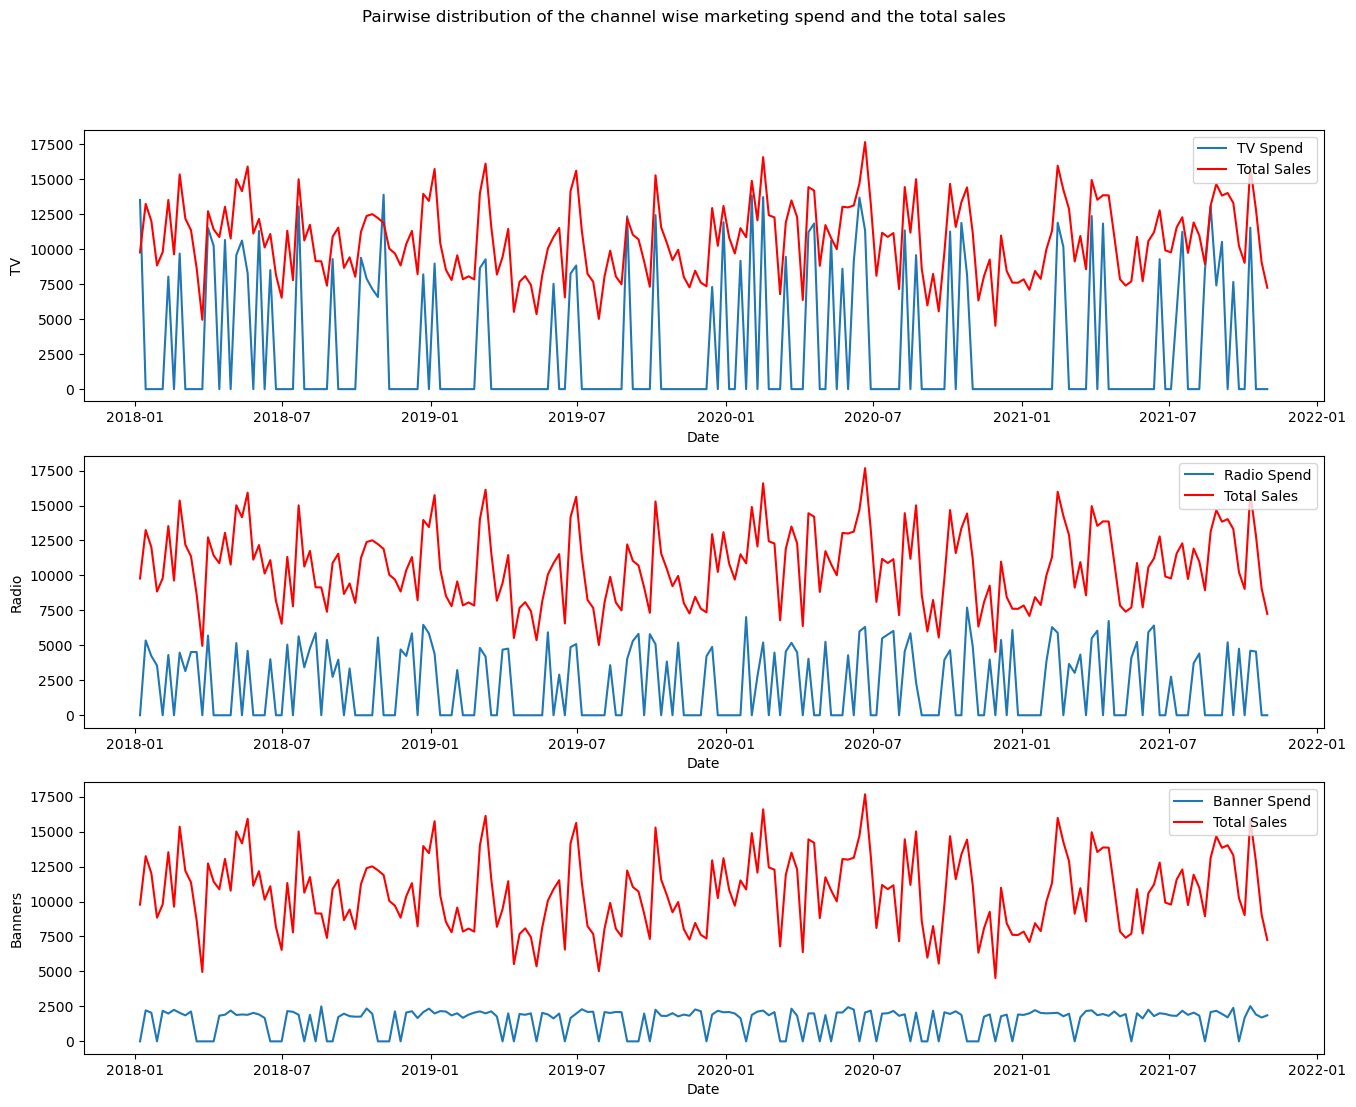

In [885]:
plt.figure(figsize = (16,12))

plt.suptitle("Pairwise distribution of the channel wise marketing spend and the total sales")
plt.subplot(311)
sns.lineplot(data = df,x = 'Date',y = 'TV',label = 'TV Spend')
sns.lineplot(data = df,x = 'Date',y = 'Sales',color = 'red',label = 'Total Sales')
plt.subplot(312)
sns.lineplot(data = df,x = 'Date',y = 'Radio',label = 'Radio Spend')
sns.lineplot(data = df,x = 'Date',y = 'Sales',color = 'red',label = 'Total Sales')
plt.subplot(313)
sns.lineplot(data = df,x = 'Date',y = 'Banners',label = 'Banner Spend')
sns.lineplot(data = df,x = 'Date',y = 'Sales',color = 'red',label = 'Total Sales')

plt.show()

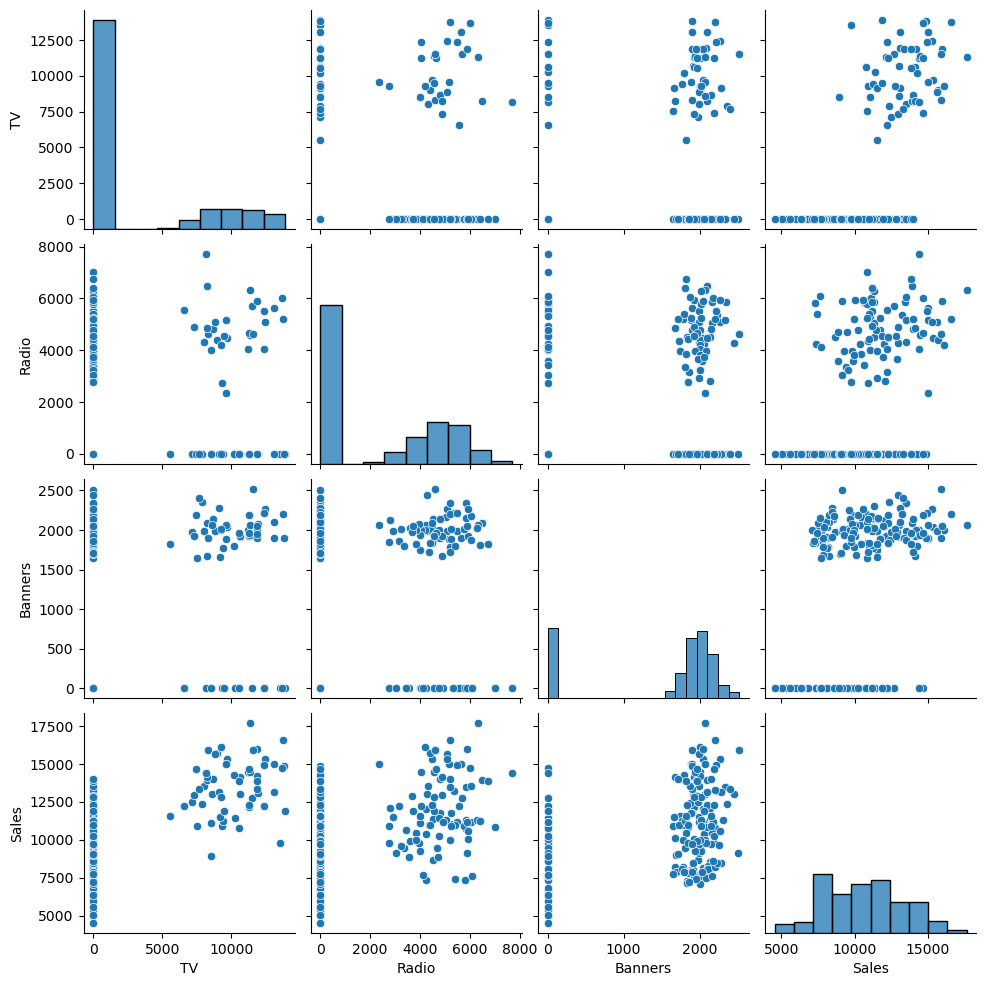

In [706]:
sns.pairplot(df[['TV','Radio','Banners','Sales']])

Banners channel have the lowest correlation across all marketing mediums

## 1. Simple Model 

Developing a basic model where the total sales is a linear equation dependent on the various marketing spends

sales = base + a * TV + b * Radio + c * Banners

The model would try to estimate the coefficients and the contributions of each of the channel to the total sales. This will help identify the ROI for each marketing channel and advise the best marketing spend strategy for the future.

In [352]:
model= LinearRegression()

x = df.drop(columns = ['Sales','Date'],axis = 1)
y = df['Sales']

print("Cross Validation Score : ",np.mean(cross_val_score(model,x,y,cv = 5)))

Cross Validation Score :  0.769159355876927


In [267]:
y_pred = model.predict(x)

In [268]:
print(f"mean absolute error: {mean_absolute_error(y,y_pred):0.2f}")
print(f"mean absolute percentage error: {mean_absolute_percentage_error(y,y_pred):0.2f}")
print(f"r2: {r2_score(y,y_pred):0.2f}")

mean absolute error: 1062.23
mean absolute percentage error: 0.11
r2: 0.78


In [269]:
df['Sales_Pred'] = y_pred

In [270]:
df['Abs_error'] = df['Sales_Pred'] - df['Sales']
df['Perc_error'] = df['Abs_error']/df['Sales']*100

In [271]:
print("Model")
print("Coefficients: ",model.coef_)
print("Intercept: ",model.intercept_)

Model
Coefficients:  [0.35968382 0.48833246 1.2159193 ]
Intercept:  6678.396933606162


### Plotting the output

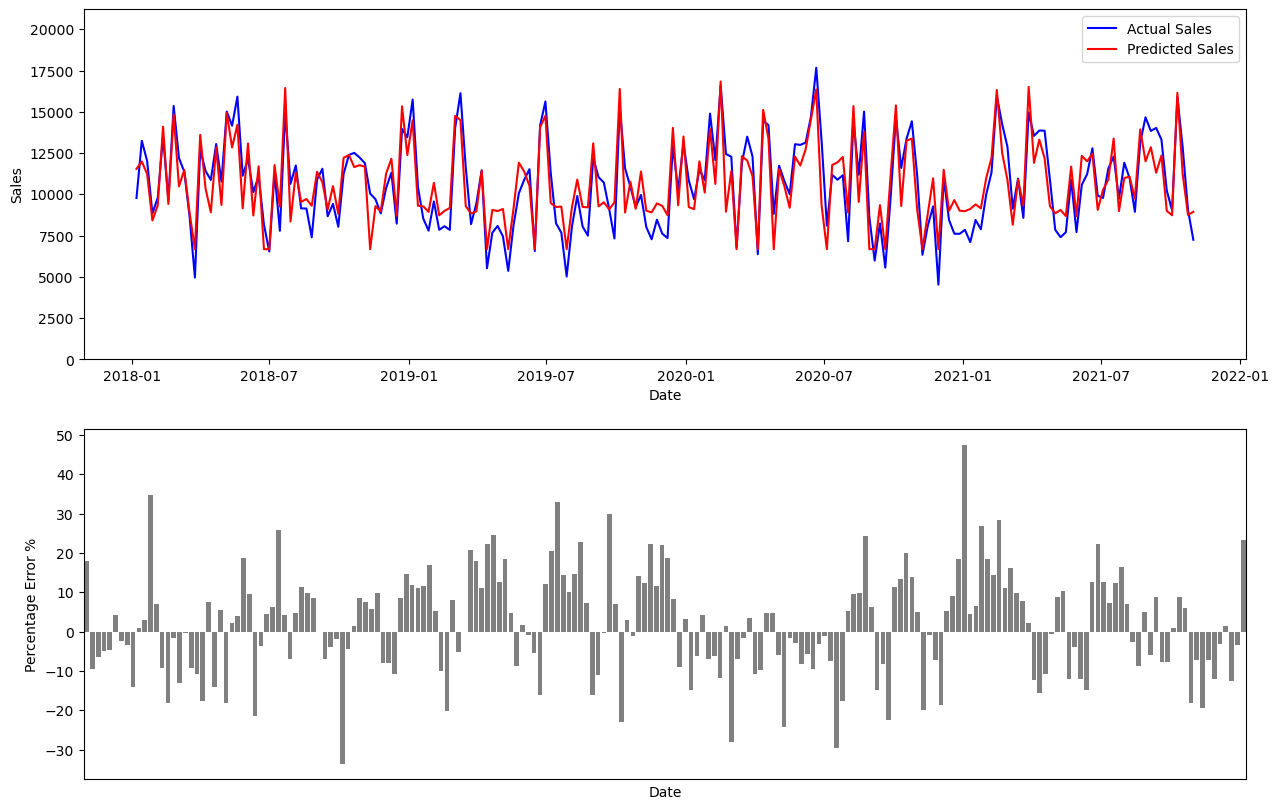

In [302]:
plt.figure(figsize = (15,10))

plt.subplot(211)
sns.lineplot(data = df,x = 'Date',y = 'Sales',color = 'b',label = "Actual Sales")
sns.lineplot(data = df,x = 'Date',y = 'Sales_Pred',color = 'r',label = "Predicted Sales")
plt.ylabel("Sales")
plt.legend()
plt.ylim(0,max(df['Sales']*1.2))

plt.subplot(212)
sns.barplot(data = df,x = 'Date',y = 'Perc_error',color = 'grey')
plt.ylabel("Percentage Error %")
plt.xticks([])
plt.show()

In [273]:
df

,Date,TV,Radio,Banners,Sales,Sales_Pred,Abs_error,Perc_error
0,2018-01-07,13528.10,0.00,0.00,9779.80,11544.235632,1764.435632,18.041633
1,2018-01-14,0.00,5349.65,2218.93,13245.19,11988.844513,-1256.345487,-9.485296
2,2018-01-21,0.00,4235.86,2046.96,12022.66,11235.843056,-786.816944,-6.544450
3,2018-01-28,0.00,3562.21,0.00,8846.95,8417.939719,-429.010281,-4.849245
4,2018-02-04,0.00,0.00,2187.29,9797.07,9337.965062,-459.104938,-4.686145
...,...,...,...,...,...,...,...,...
195,2021-10-03,0.00,0.00,1691.68,9030.17,8735.343297,-294.826703,-3.264908
196,2021-10-10,11543.58,4615.35,2518.88,15904.11,16147.015942,242.905942,1.527316
197,2021-10-17,0.00,4556.16,1919.19,12839.29,11236.897935,-1602.392065,-12.480379
198,2021-10-24,0.00,0.00,1707.65,9063.45,8754.761529,-308.688471,-3.405861


In [274]:
df[['TV_Sales','Radio_Sales','Banner_Sales']] = model.coef_ * df[['TV','Radio','Banners']]

In [275]:
df['Base_Sales'] = model.intercept_

In [276]:
df

,Date,TV,Radio,Banners,Sales,Sales_Pred,Abs_error,Perc_error,TV_Sales,Radio_Sales,Banner_Sales,Base_Sales
0,2018-01-07,13528.10,0.00,0.00,9779.80,11544.235632,1764.435632,18.041633,4865.838699,0.000000,0.000000,6678.396934
1,2018-01-14,0.00,5349.65,2218.93,13245.19,11988.844513,-1256.345487,-9.485296,0.000000,2612.407764,2698.039815,6678.396934
2,2018-01-21,0.00,4235.86,2046.96,12022.66,11235.843056,-786.816944,-6.544450,0.000000,2068.507949,2488.938173,6678.396934
3,2018-01-28,0.00,3562.21,0.00,8846.95,8417.939719,-429.010281,-4.849245,0.000000,1739.542785,0.000000,6678.396934
4,2018-02-04,0.00,0.00,2187.29,9797.07,9337.965062,-459.104938,-4.686145,0.000000,0.000000,2659.568129,6678.396934
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2021-10-03,0.00,0.00,1691.68,9030.17,8735.343297,-294.826703,-3.264908,0.000000,0.000000,2056.946364,6678.396934
196,2021-10-10,11543.58,4615.35,2518.88,15904.11,16147.015942,242.905942,1.527316,4152.038962,2253.825236,3062.754810,6678.396934
197,2021-10-17,0.00,4556.16,1919.19,12839.29,11236.897935,-1602.392065,-12.480379,0.000000,2224.920837,2333.580164,6678.396934
198,2021-10-24,0.00,0.00,1707.65,9063.45,8754.761529,-308.688471,-3.405861,0.000000,0.000000,2076.364595,6678.396934


In [277]:
def safe_divide(x, y):
    if y != 0:
        return x / y
    else:
        return x

df['TV_Sales'] = df.apply(lambda row: safe_divide(row['TV_Sales'], 1+row['Perc_error']/100), axis=1)
df['Radio_Sales'] = df.apply(lambda row: safe_divide(row['Radio_Sales'], 1+row['Perc_error']/100), axis=1)
df['Banner_Sales'] = df.apply(lambda row: safe_divide(row['Banner_Sales'], 1+row['Perc_error']/100), axis=1)
df['Base_Sales'] = df.apply(lambda row: safe_divide(row['Base_Sales'], 1+row['Perc_error']/100), axis=1)

In [278]:
df

,Date,TV,Radio,Banners,Sales,Sales_Pred,Abs_error,Perc_error,TV_Sales,Radio_Sales,Banner_Sales,Base_Sales
0,2018-01-07,13528.10,0.00,0.00,9779.80,11544.235632,1764.435632,18.041633,4122.137734,0.000000,0.000000,5657.662266
1,2018-01-14,0.00,5349.65,2218.93,13245.19,11988.844513,-1256.345487,-9.485296,0.000000,2886.169485,2980.775165,7378.245350
2,2018-01-21,0.00,4235.86,2046.96,12022.66,11235.843056,-786.816944,-6.544450,0.000000,2213.360195,2663.232057,7146.067747
3,2018-01-28,0.00,3562.21,0.00,8846.95,8417.939719,-429.010281,-4.849245,0.000000,1828.196513,0.000000,7018.753487
4,2018-02-04,0.00,0.00,2187.29,9797.07,9337.965062,-459.104938,-4.686145,0.000000,0.000000,2790.326902,7006.743098
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2021-10-03,0.00,0.00,1691.68,9030.17,8735.343297,-294.826703,-3.264908,0.000000,0.000000,2126.370391,6903.799609
196,2021-10-10,11543.58,4615.35,2518.88,15904.11,16147.015942,242.905942,1.527316,4089.578199,2219.920052,3016.680579,6577.931169
197,2021-10-17,0.00,4556.16,1919.19,12839.29,11236.897935,-1602.392065,-12.480379,0.000000,2542.196612,2666.350859,7630.742529
198,2021-10-24,0.00,0.00,1707.65,9063.45,8754.761529,-308.688471,-3.405861,0.000000,0.000000,2149.576162,6913.873838


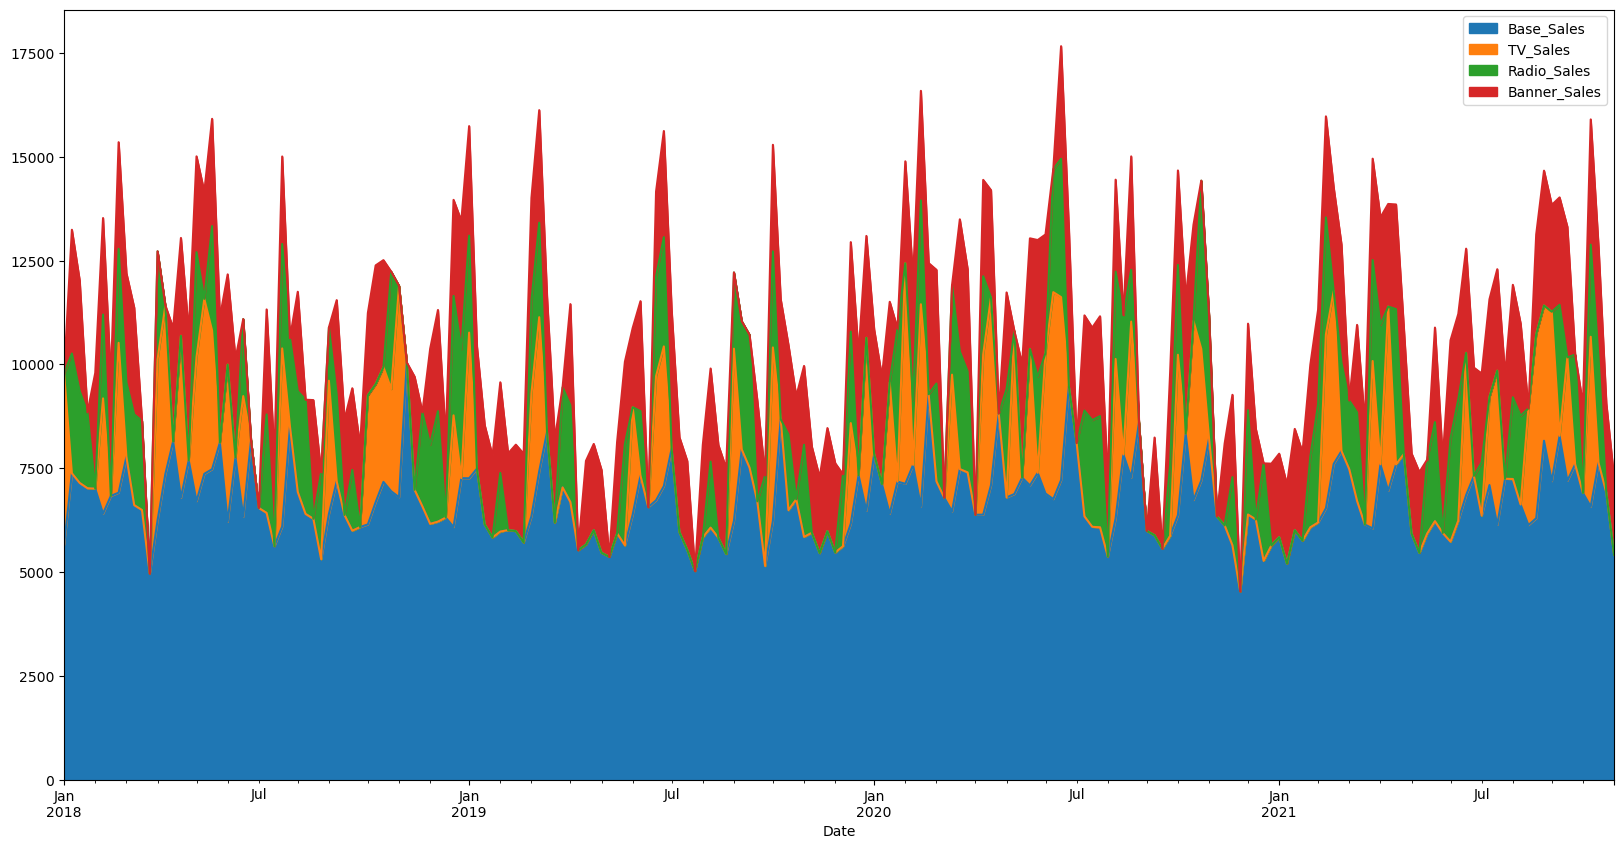

In [300]:
sns.color_palette(palette="Blues")
df[['Date','Base_Sales','TV_Sales','Radio_Sales','Banner_Sales']].plot(kind = 'area',x = 'Date',figsize = (20,10))
plt.show()

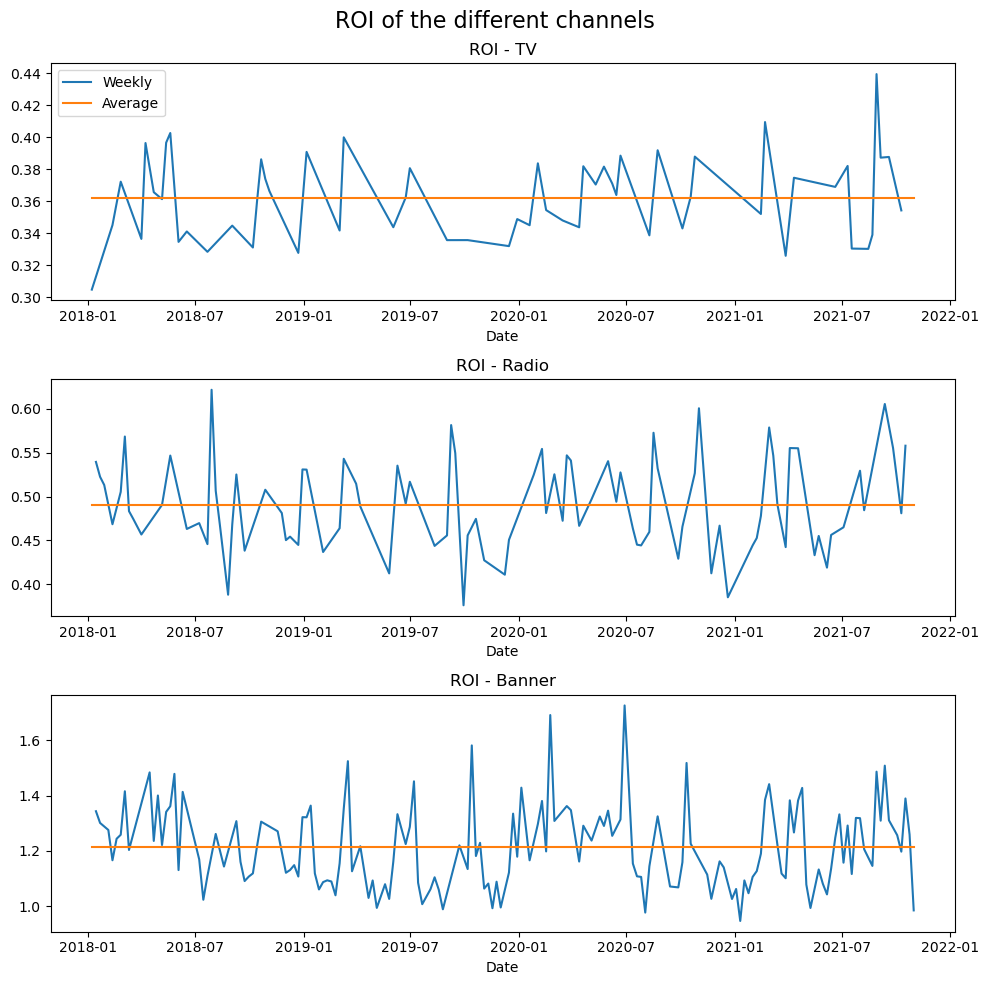

In [323]:
plt.figure(figsize = (10,10))
plt.suptitle("ROI of the different channels",size = 16)

plt.subplot(311)
plt.title("ROI - TV")
sns.lineplot(data = df,x = 'Date',y = df['TV_Sales']/df['TV'],label = 'Weekly')
sns.lineplot(data = df,x = 'Date',y = np.mean(df['TV_Sales']/df['TV']),label = 'Average')

plt.subplot(312)
plt.title("ROI - Radio")
sns.lineplot(data = df,x = 'Date',y = df['Radio_Sales']/df['Radio'])
sns.lineplot(data = df,x = 'Date',y = np.mean(df['Radio_Sales']/df['Radio']))

plt.subplot(313)
plt.title("ROI - Banner")
sns.lineplot(data = df,x = 'Date',y = df['Banner_Sales']/df['Banners'])
sns.lineplot(data = df,x = 'Date',y = np.mean(df['Banner_Sales']/df['Banners']))

plt.tight_layout()

## 2. Intermediate Model with Adstock and Diminishing Returns factor

The current model represents an unrealistic scenario where sales could be increased infinitely with higher marketing spends. Hence this needs to be incorporated within a more complex model

The following adjustments would be made

#### 1. AdStock Lagged Effect :
The impact of an marketing activity is not immediate and can carryover a longer period of time.
#### 2. Diminishing Returns
The incremental gain from every additional spend on marketing will gradually reduce

In [703]:
df = pd.read_csv("mmm_data.csv",parse_dates=['Date'])

### Adding adstock column and diminishing returns

adstock(t) = adstock(t-1)*beta + spend(t)

dim_returns = adstock(t)^alpha

In [707]:
df

,Date,TV,Radio,Banners,Sales
0,2018-01-07,13528.10,0.00,0.00,9779.80
1,2018-01-14,0.00,5349.65,2218.93,13245.19
2,2018-01-21,0.00,4235.86,2046.96,12022.66
3,2018-01-28,0.00,3562.21,0.00,8846.95
4,2018-02-04,0.00,0.00,2187.29,9797.07
...,...,...,...,...,...
195,2021-10-03,0.00,0.00,1691.68,9030.17
196,2021-10-10,11543.58,4615.35,2518.88,15904.11
197,2021-10-17,0.00,4556.16,1919.19,12839.29
198,2021-10-24,0.00,0.00,1707.65,9063.45


In [732]:
def df_transformations(df,alpha_tv,beta_tv,alpha_radio,beta_radio,alpha_banners,beta_banners):
    for i in range(0,len(df)):
        if i == 0:
            df.loc[i,'TV_adstock'] = np.power(df.loc[i,'TV'],alpha_tv)
            df.loc[i,'Radio_adstock'] = np.power(df.loc[i,'Radio'],alpha_radio)
            df.loc[i,'Banners_adstock'] = np.power(df.loc[i,'Banners'],alpha_banners)
        else:
            df.loc[i,'TV_adstock'] = np.power(df.loc[i,'TV'] + df.loc[i-1,'TV_adstock'] * beta_tv,alpha_tv)
            df.loc[i,'Radio_adstock'] = np.power(df.loc[i,'Radio'] + df.loc[i-1,'Radio_adstock'] * beta_radio,alpha_radio)
            df.loc[i,'Banners_adstock'] = np.power(df.loc[i,'Banners'] + df.loc[i-1,'Banners_adstock'] * beta_banners,alpha_banners)
                      
    return df

In [782]:
df_transformed = df_transformations(df,0.8969262716601483,0.9987428763892082,0.7111902763436786,0.5728586479418164,0.654145045011662,0.6645408387962348)

In [783]:
best_params

{'alpha_banners': 0.654145045011662,
 'alpha_radio': 0.7111902763436786,
 'alpha_tv': 0.8969262716601483,
 'beta_banners': 0.6645408387962348,
 'beta_radio': 0.5728586479418164,
 'beta_tv': 0.9987428763892082}

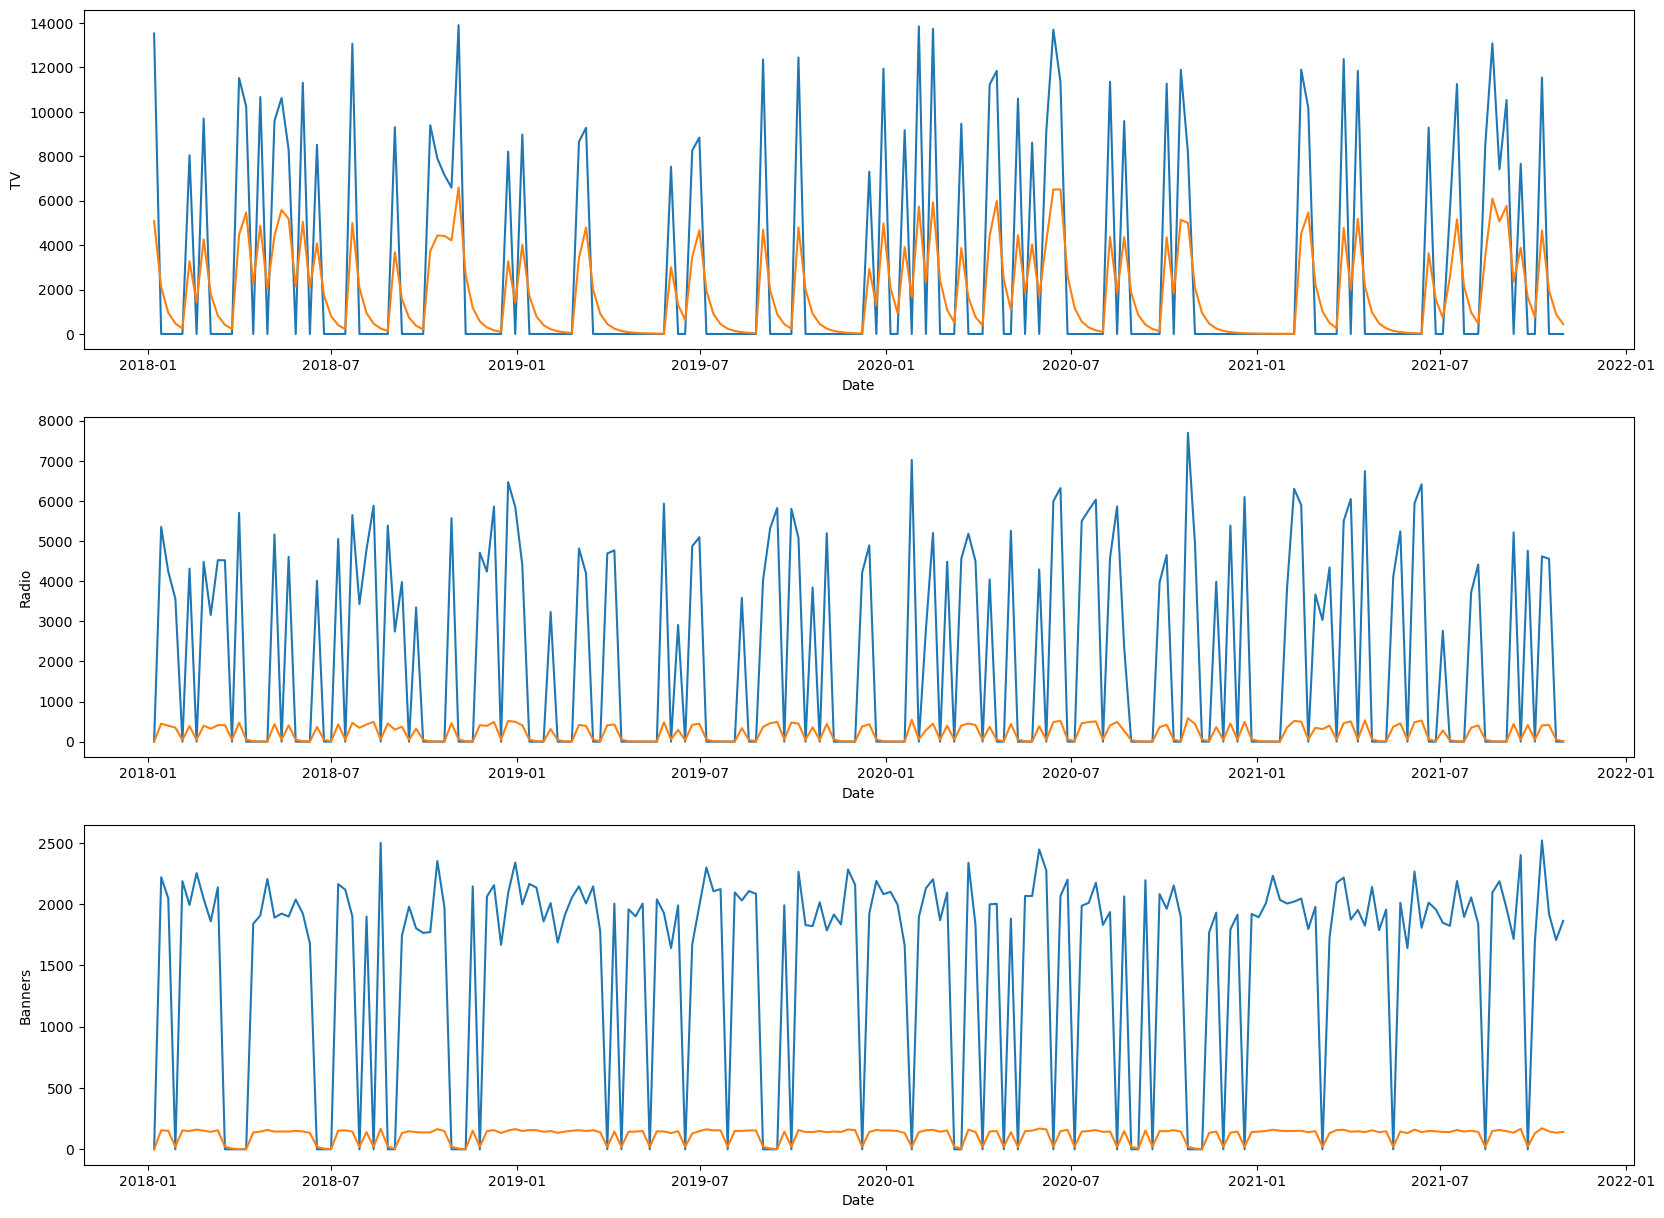

In [784]:
plt.figure(figsize = (20,15))

plt.subplot(311)
sns.lineplot(data = df,x = 'Date',y = 'TV')
sns.lineplot(data = df,x = 'Date',y = 'TV_adstock')

plt.subplot(312)
sns.lineplot(data = df,x = 'Date',y = 'Radio')
sns.lineplot(data = df,x = 'Date',y = 'Radio_adstock')

plt.subplot(313)
sns.lineplot(data = df,x = 'Date',y = 'Banners')
sns.lineplot(data = df,x = 'Date',y = 'Banners_adstock')

plt.show()

### Building the model

In [785]:
model = LinearRegression()

In [786]:
x = df_transformed.drop(columns = ['Date','Sales'],axis = 1)
y = df_transformed['Sales']

In [787]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [788]:
cross_val_score(model,x_train,y_train,cv=TimeSeriesSplit(),scoring = 'r2')

array([0.92922566, 0.97929141, 0.97678064, 0.96505171, 0.95322265])

In [789]:
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)

In [790]:
print(f"mean squared error: {mean_squared_error(y_train,y_train_pred):0.2f}")
print(f"mean absolute error: {mean_absolute_error(y_train,y_train_pred):0.2f}")
print(f"r2: {r2_score(y_train,y_train_pred):0.2f}")

mean squared error: 235060.86
mean absolute error: 393.72
r2: 0.97


In [791]:
y_test_pred = model.predict(x_test)

In [792]:
print(f"mean squared error: {mean_squared_error(y_test,y_test_pred):0.2f}")
print(f"mean absolute error: {mean_absolute_error(y_test,y_test_pred):0.2f}")
print(f"r2: {r2_score(y_test,y_test_pred):0.2f}")

mean squared error: 439576.65
mean absolute error: 519.88
r2: 0.90


### Performing a manual grid search to optimize for alpha and beta values

In [812]:
alpha_range = np.arange(0,1,0.01)

In [813]:
beta_range = np.arange(0,1,0.01)

In [826]:
def objective(params):
    alpha_tv, beta_tv, alpha_radio, beta_radio, alpha_banners, beta_banners = params
    df_transformed = df_transformations(df,alpha_tv, beta_tv, alpha_radio, beta_radio, alpha_banners, beta_banners)
    model = LinearRegression()
    x = df_transformed.drop(columns = ['Date','Sales','TV','Radio','Banners'],axis = 1)
    y = df_transformed['Sales']

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
    
    model.fit(x_train,y_train)
    score = cross_val_score(model,x_train,y_train,cv=TimeSeriesSplit(),scoring = 'r2').mean()
    return {'loss':-score,'status':STATUS_OK}

In [827]:
search_space = [
    hp.uniform('alpha_tv', 0.1, 1),
    hp.uniform('beta_tv', 0.1, 1),
    hp.uniform('alpha_radio', 0.1, 1),
    hp.uniform('beta_radio', 0.1, 1),
    hp.uniform('alpha_banners', 0.1, 1),
    hp.uniform('beta_banners', 0.1, 1),
]

In [828]:
algorithm=tpe.suggest

In [829]:
best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  max_evals=200)

100%|██████| 200/200 [00:09<00:00, 21.34trial/s, best loss: -0.9479878055735791]


In [818]:
best_params

{'alpha_banners': 0.6583783004238227,
 'alpha_radio': 0.9748188876296262,
 'alpha_tv': 0.8543208727457007,
 'beta_banners': 0.24594569331152769,
 'beta_radio': 0.5410698299927826,
 'beta_tv': 0.9390365755398694}

#### Using the best parameters for building the model

In [830]:
df_transformed = df_transformations(df,best_params['alpha_tv'],best_params['beta_tv'],best_params['alpha_radio'],best_params['beta_radio'],best_params['alpha_banners'],best_params['beta_banners'])

model = LinearRegression()
x = df_transformed.drop(columns = ['Date','Sales','TV','Radio','Banners'],axis = 1)
y = df_transformed['Sales']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

model.fit(x_train,y_train)
score = cross_val_score(model,x_train,y_train,cv=TimeSeriesSplit(),scoring = 'r2').mean()

In [833]:
print(f"R2 Score: {score:0.3f}")

R2 Score: 0.944


In [834]:
y_test_pred = model.predict(x_test)

In [836]:
print(f"R2 score for the validation data : {r2_score(y_test,y_test_pred):0.2f}")

R2 score for the validation data : 0.95


#### Plotting the predicted values against the test data

In [838]:
model.coef_

array([ 0.61435445, 43.08491606, 70.29274208])

In [839]:
model.intercept_

4910.070373571842

In [840]:
df_transformed

,Date,TV,Radio,Banners,Sales,TV_adstock,Radio_adstock,Banners_adstock
0,2018-01-07,13528.10,0.00,0.00,9779.80,8372.643696,0.000000,0.000000
1,2018-01-14,0.00,5349.65,2218.93,13245.19,4240.892158,64.969328,41.581684
2,2018-01-21,0.00,4235.86,2046.96,12022.66,2223.062690,58.380403,40.191843
3,2018-01-28,0.00,3562.21,0.00,8846.95,1203.911390,53.689350,4.330909
4,2018-02-04,0.00,0.00,2187.29,9797.07,672.468655,6.540448,41.314118
...,...,...,...,...,...,...,...,...
195,2021-10-03,0.00,0.00,1691.68,9030.17,2014.367430,6.981971,36.490840
196,2021-10-10,11543.58,4615.35,2518.88,15904.11,8140.656763,60.508431,44.371462
197,2021-10-17,0.00,4556.16,1919.19,12839.29,4129.234761,60.433622,38.984819
198,2021-10-24,0.00,0.00,1707.65,9063.45,2167.447176,6.927770,36.840542


#### Adding a column for Predicted Sales

In [850]:
x = df_transformed[['TV_adstock','Radio_adstock','Banners_adstock']]
sales_pred = model.predict(x)
df_transformed['Sales_Pred'] = sales_pred

In [868]:
df_transformed

,Date,TV,Radio,Banners,Sales,TV_adstock,Radio_adstock,Banners_adstock,Sales_Pred
0,2018-01-07,13528.10,0.00,0.00,9779.80,8372.643696,0.000000,0.000000,10053.841275
1,2018-01-14,0.00,5349.65,2218.93,13245.19,4240.892158,64.969328,41.581684,13237.569960
2,2018-01-21,0.00,4235.86,2046.96,12022.66,2223.062690,58.380403,40.191843,11616.328422
3,2018-01-28,0.00,3562.21,0.00,8846.95,1203.911390,53.689350,4.330909,8267.331316
4,2018-02-04,0.00,0.00,2187.29,9797.07,672.468655,6.540448,41.314118,8509.081753
...,...,...,...,...,...,...,...,...,...
195,2021-10-03,0.00,0.00,1691.68,9030.17,2014.367430,6.981971,36.490840,9013.464804
196,2021-10-10,11543.58,4615.35,2518.88,15904.11,8140.656763,60.508431,44.371462,15637.311472
197,2021-10-17,0.00,4556.16,1919.19,12839.29,4129.234761,60.433622,38.984819,12791.011510
198,2021-10-24,0.00,0.00,1707.65,9063.45,2167.447176,6.927770,36.840542,9129.756286


In [871]:
df_transformed['Perc_error'] = df_transformed.apply(lambda row: row['Sales_Pred']/row['Sales'] - 1,axis = 1)

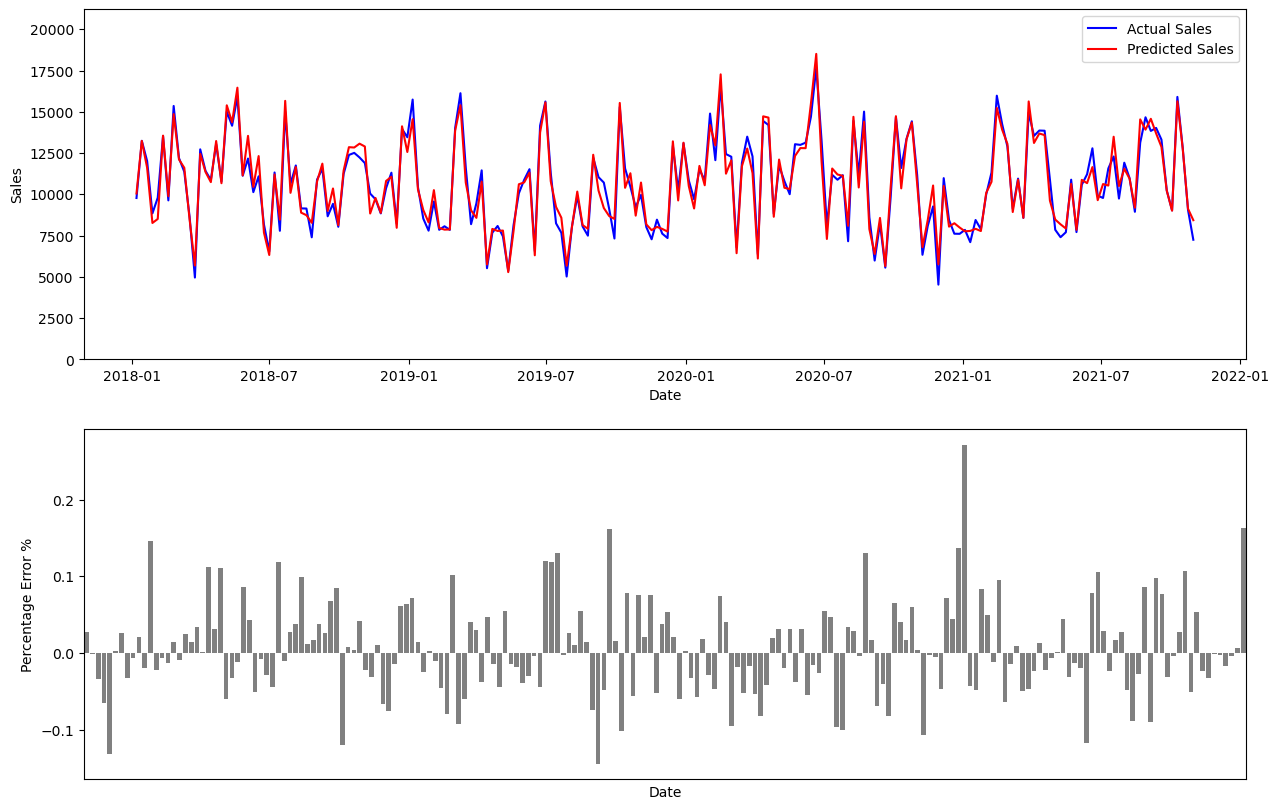

In [872]:
plt.figure(figsize = (15,10))

plt.subplot(211)
sns.lineplot(data = df,x = 'Date',y = 'Sales',color = 'b',label = "Actual Sales")
sns.lineplot(data = df,x = 'Date',y = 'Sales_Pred',color = 'r',label = "Predicted Sales")
plt.ylabel("Sales")
plt.legend()
plt.ylim(0,max(df['Sales']*1.2))

plt.subplot(212)
sns.barplot(data = df,x = 'Date',y = 'Perc_error',color = 'grey')
plt.ylabel("Percentage Error %")
plt.xticks([])
plt.show()

The new predicted values show a much stronger fit compared to the basic model 